# Mass per module area calculations for Encapsulants and Backsheets

In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

Import the supporting material files

## Encapsulants

In [2]:
cwd = os.getcwd() #grabs current working directory
skipcols = ['Source', 'Notes']
encapsulants_thick_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/encapsulants-thickness-micron.csv",
                                     index_col='year', usecols=lambda x: x not in skipcols)
encapsulants_market_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/encapsulants-marketshares-global.csv",
                                      index_col='year', usecols=lambda x: x not in skipcols)

In [3]:
#what materials:
print(encapsulants_thick_raw.columns)
print(encapsulants_market_raw.columns)
#there is one column in marketshare that is a blend of two materials

Index(['EVA', 'TPU', 'PVB', 'Polyolefin', 'PDMS'], dtype='object')
Index(['EVA', 'EVA+PO', 'Polyolefin', 'TPU', 'PVB', 'PDMS'], dtype='object')


ITRPV provides the thickness and marketshare data for the different encapsulants. For each material, the thickness needs to be multiplied by the material density to obtain mass per module area.

* EVA: Product datasheets from several companies report values of 0.96 and 0.92 g/cm^3 spanning from 2013 to 2021.
* TPU: 
* PVB: 1.075 g/cm^3 from wmcglass, 
* Polyolefin: 0.88 g/cm^ from almaden, 0.8683 to 0.88 g/cm^3 from 3M
* PDMS: 965 kg/m3 from wikipedia

Create a dataframe with the densities of the different materials:

In [4]:
#create dictionary with these materials, 1E6 is converting to g/m3 from cm3
encaps_density = {
    'EVA' : np.mean([0.96,0.92])*1E6, #g/m^3
    'TPU' : 1.21*1E6, #https://bitfab.io/
    'PVB' : 1.075*1E6, #g/m^3
    'Polyolefin' : 0.88*1E6, #g/m^3
    'PDMS' : 0.965*1E6 #g/m3
}
print(encaps_density)

{'EVA': 940000.0, 'TPU': 1210000.0, 'PVB': 1075000.0, 'Polyolefin': 880000.0, 'PDMS': 965000.0}


First, change the marketshares into percentages, and fill in missing values.

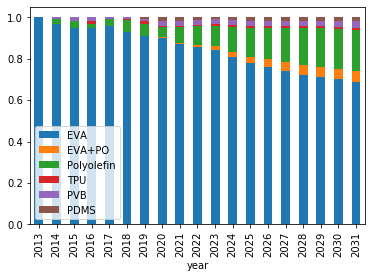

In [5]:
encapsulants_market_pct = encapsulants_market_raw/100
#interpolate
encap_market_pct_interp = encapsulants_market_pct.interpolate(method='linear',axis=0,limit=2,limit_area='inside')
#fill na with 0
encap_market_pct_full = encap_market_pct_interp.fillna(0.0)

check = pd.DataFrame(encap_market_pct_full.agg("sum", axis="columns"))
#print(check)
#make a bar plot
encap_market_pct_full.plot(kind='bar', stacked=True)

In [9]:
#check if marketshare and thickness dataframes have same index
if (len(encap_market_pct_full.index) == len(encapsulants_thick_raw.index)) & (encap_market_pct_full.index[0] == encapsulants_thick_raw.index[0]):
    print("indexes are equal, proceed.")
else:
    print("check dataframe index")

print(encap_market_pct_full.columns)
print(encapsulants_thick_raw.columns)

indexes are equal, proceed.
Index(['EVA', 'EVA+PO', 'Polyolefin', 'TPU', 'PVB', 'PDMS'], dtype='object')
Index(['EVA', 'TPU', 'PVB', 'Polyolefin', 'PDMS'], dtype='object')


In [20]:
#fill in thickness dataframe
encapsulants_thick_interp = encapsulants_thick_raw.interpolate(method='linear',axis=0, limit_direction='both')
#thickness data is in micron, convert to meter
encaps_thick_m = encapsulants_thick_interp/1E6
print(encaps_thick_m)

           EVA       TPU       PVB  Polyolefin      PDMS
year                                                    
2013  0.000450  0.000450  0.000500    0.000475  0.000500
2014  0.000450  0.000450  0.000500    0.000475  0.000500
2015  0.000450  0.000450  0.000500    0.000475  0.000500
2016  0.000450  0.000450  0.000500    0.000475  0.000500
2017  0.000450  0.000450  0.000500    0.000475  0.000500
2018  0.000450  0.000450  0.000500    0.000475  0.000500
2019  0.000450  0.000450  0.000500    0.000475  0.000500
2020  0.000450  0.000450  0.000500    0.000475  0.000500
2021  0.000450  0.000450  0.000500    0.000475  0.000500
2022  0.000450  0.000438  0.000487    0.000463  0.000475
2023  0.000450  0.000425  0.000475    0.000450  0.000450
2024  0.000438  0.000420  0.000452    0.000440  0.000435
2025  0.000425  0.000415  0.000430    0.000430  0.000420
2026  0.000417  0.000410  0.000420    0.000420  0.000413
2027  0.000408  0.000405  0.000410    0.000410  0.000407
2028  0.000400  0.000400  0.000

Now multiply by densities to get mass per meter sq., then weight by marketshare

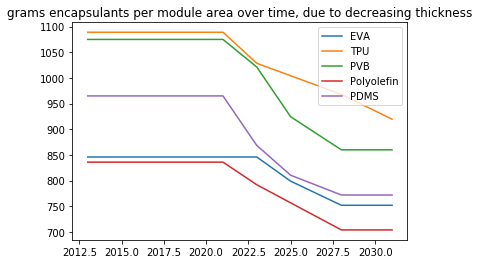

In [38]:
#multiply thickness times density to get mass per area (g/m^2)
encaps_bymat_gpm2 = pd.DataFrame(encaps_thick_m.mul(encaps_density, 'columns'))
#multiply by number of sheets of material used in PV module (usually 2)
encaps_bymat_gpm2=encaps_bymat_gpm2*2

plt.plot(encaps_bymat_gpm2)
plt.title('grams encapsulants per module area over time, due to decreasing thickness')
plt.legend(encaps_bymat_gpm2.columns)

Now aggregate it down into a single "encapsulant" baseline

In [39]:
#drop the EVA+PO column from the marketshare
encap_market = encap_market_pct_full.drop('EVA+PO', axis='columns')

#now multiply marketshare by mass per area
encaps_gpm2 = pd.DataFrame(encaps_bymat_gpm2.mul(encap_market, 'columns'))
#aggregate down to a single column
encapsulant_gpm2 = pd.DataFrame(encaps_gpm2.agg("sum", axis="columns"))
encapsulant_gpm2.columns = ['Encapsulant_g_per_m2']
print(encapsulant_gpm2)

      Encapsulant_g_per_m2
year                      
2013            846.000000
2014            848.090000
2015            850.280000
2016            852.810000
2017            847.990000
2018            848.955000
2019            851.310000
2020            849.445000
2021            849.145000
2022            839.244375
2023            829.235000
2024            801.367750
2025            773.917000
2026            752.614000
2027            731.468333
2028            710.480000
2029            710.358667
2030            710.237333
2031            710.116000


In [41]:
#print to csv
encapsulant_gpm2.to_csv(cwd+'/../../../PV_ICE/baselines/SupportingMaterial/output_encapsulant_gpm2.csv', index=True)